In [1]:
import torch
import argparse
import numpy as np
import random
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
from backdoor import *
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
acc

array([[96.9, 93.5, 90.9, 90.1, 88.2, 88.2, 88.4, 87.4, 87.1, 86.1],
       [ 0. , 95.3, 92.4, 89.2, 87.8, 86.1, 86.4, 85.4, 84.9, 83.1],
       [ 0. ,  0. , 91.6, 90.1, 86.6, 86.3, 85.2, 84.1, 84.3, 84.2],
       [ 0. ,  0. ,  0. , 89. , 87.3, 86.6, 85. , 84.3, 83.2, 83.3],
       [ 0. ,  0. ,  0. ,  0. , 91.2, 90.6, 89.9, 89.8, 88.6, 86.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. , 82.8, 81. , 81.3, 80.8, 80.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , 86.7, 83.5, 84.4, 84. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 86.1, 84.4, 84.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 90.7, 87.9],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 86.8]])

In [9]:
np.round(asr,2)

array([[0.9 , 0.89, 0.9 , 0.89, 0.89, 0.86, 0.88, 0.88, 0.86, 0.84],
       [0.  , 0.9 , 0.91, 0.89, 0.88, 0.86, 0.88, 0.87, 0.86, 0.84],
       [0.  , 0.  , 0.81, 0.78, 0.78, 0.78, 0.79, 0.78, 0.78, 0.77],
       [0.  , 0.  , 0.  , 0.93, 0.92, 0.92, 0.93, 0.92, 0.9 , 0.9 ],
       [0.  , 0.  , 0.  , 0.  , 0.85, 0.83, 0.84, 0.84, 0.83, 0.82],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.89, 0.92, 0.89, 0.89, 0.88],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.93, 0.92, 0.92, 0.9 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.92, 0.91, 0.9 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.84, 0.82],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.87]])

In [12]:

trigger = torch.load('./trigger/trigger_base.pt',map_location=torch.device('cpu'))

C:\Users\vaish\AppData\Local\Temp\ipykernel_67560\2747778900.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trigger = torch.load('./trigger/trigger_base.pt',map_locatio

In [21]:
from datasets import build_continual_dataloader
from vision_transformer import create_model
from configs.cifar100_l2p import get_args_parser

ImportError: cannot import name 'create_model' from 'vision_transformer' (d:\Thesis\L2P_Backdoor\vision_transformer.py)

In [14]:
import sys

sys.argv ="""/home/woody/iwi1/iwi1102h/software/private/conda/envs/l2p/bin/python -m torch.distributed.launch \
        --nproc_per_node=1 \
        --use_env main.py \
        cifar100_l2p \
        --model vit_base_patch16_224 \
        --batch-size 16 \
        --data-path ./../local_datasets/ \
        --output_dir ./output \
        --use_trigger false \
        --poison_rate 0.1 """.split('\n')

parser = argparse.ArgumentParser('L2P training and evaluation configs')
# config = parser.parse_known_args()[-1][0]

subparser = parser.add_subparsers(dest='subparser_name')


config_parser = subparser.add_parser('cifar100_l2p', help='Split-CIFAR100 L2P configs')


seed = 1

get_args_parser(config_parser)

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

cudnn.benchmark = True
# args = argparse.Namespace(verbose=False, verbose_1=False)
args = config_parser.parse_args()

import utils
utils.init_distributed_mode(args)

Not using distributed mode


In [20]:
args

Namespace(aa=None, batch_size=16, batchwise_prompt=True, clip_grad=1.0, color_jitter=None, cooldown_epochs=10, data_path='./local_datasets/', dataset='Split-CIFAR100', decay_epochs=30, decay_rate=0.1, device='cuda', dist_url='env://', distributed=False, drop=0.0, drop_path=0.0, embedding_key='cls', epochs=5, eval=False, freeze=['blocks', 'patch_embed', 'cls_token', 'norm', 'pos_embed'], global_pool='token', head_type='prompt', initializer='uniform', input_size=224, length=5, lr=0.03, lr_noise=None, lr_noise_pct=0.67, lr_noise_std=1.0, min_lr=1e-05, model='vit_base_patch16_224', momentum=0.9, nb_classes=10, num_tasks=10, num_workers=4, opt='adam', opt_betas=(0.9, 0.999), opt_eps=1e-08, output_dir='./output', p_class_id=0, p_task_id=9, patience_epochs=10, pin_mem=True, poison_rate=0.1, predefined_key='', pretrained=True, print_freq=10, prompt_key=True, prompt_key_init='uniform', prompt_pool=True, pull_constraint=True, pull_constraint_coeff=0.1, recount=1, reinit_optimizer=True, remode='p

In [22]:
args.nb_classes = 10
model = create_model(
        args.model,
        pretrained=args.pretrained,
        num_classes=args.nb_classes,
        drop_rate=args.drop,
        drop_path_rate=args.drop_path,
        drop_block_rate=None,
        prompt_length=args.length,
        embedding_key=args.embedding_key,
        prompt_init=args.prompt_key_init,
        prompt_pool=args.prompt_pool,
        prompt_key=args.prompt_key,
        pool_size=args.size,
        top_k=args.top_k,
        batchwise_prompt=args.batchwise_prompt,
        prompt_key_init=args.prompt_key_init,
        head_type=args.head_type,
        use_prompt_mask=args.use_prompt_mask)

In [ ]:
model.parameters

TypeError: 'method' object is not subscriptable

In [ ]:
y = None
for x in data_loader[0]['train']:
    y = x
    break

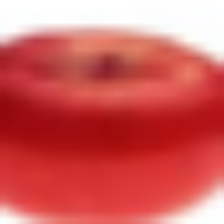

In [ ]:
TF.to_pil_image(y[0][0])

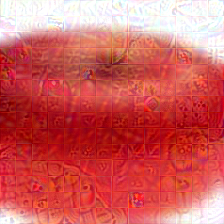

In [ ]:
y_ = torch.clamp(apply_noise_patch(trigger,y[0][0].clone(),mode='add'),0,1)

TF.to_pil_image(y_)

In [ ]:

  # assuming your image in x
h_img = TF.to_pil_image(trigger[0])

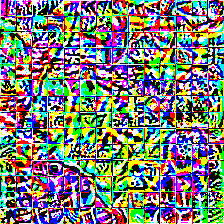

In [ ]:
h_img

In [2]:
h_img.save('heat.png')

NameError: name 'h_img' is not defined

In [14]:
acc = np.load('./output/stats/trigger_0_0_16.255.ptacc_matrix_9.npy')
asr = np.load('./output/stats/trigger_0_0_16.255.ptasr_matrix_9.npy')

In [15]:
acc

array([[96.6, 93.5, 90.2, 90.2, 87.3, 87. , 87.5, 86.8, 85.4, 85.3],
       [ 0. , 93.7, 91.9, 87.9, 84.2, 83.1, 81.6, 80.1, 79. , 77.7],
       [ 0. ,  0. , 92.1, 89.9, 87.7, 84.6, 83.7, 82.2, 82. , 82.4],
       [ 0. ,  0. ,  0. , 91. , 89.2, 87.8, 86.5, 87.1, 85.6, 85.1],
       [ 0. ,  0. ,  0. ,  0. , 91.6, 91. , 90.3, 90.6, 88.7, 86.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. , 82.8, 80.5, 81.8, 78.9, 78.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , 86.7, 83.5, 83.3, 82.3],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 83.7, 82.2, 81.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 87.8, 86.8],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 89.4]])

In [16]:
ACC_no_poison = [97.300,92.700,89.900, 88.400, 87.900,86.300,88.400,87.400, 85.200,83.900]

In [17]:
fig = plt.figure()

num_tasks = 10

acc_mean_model = []
acc_mean_task = []

asr_mean_model = []
asr_mean_task = []

for i in range(num_tasks):
    acc_mean_model.append(acc[:,i].sum()/(i+1))
    acc_mean_task.append(acc[i,:].sum()/(num_tasks-(i)))

    asr_mean_model.append(asr[:,i].sum()/(i+1))
    asr_mean_task.append(asr[i,:].sum()/(num_tasks-(i)))



<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Task id')

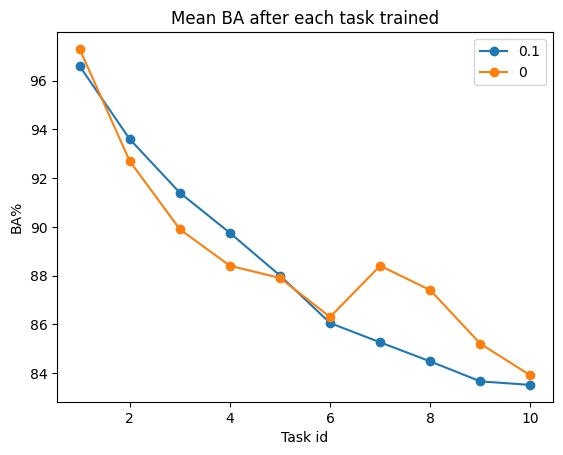

In [25]:

data = [[acc_mean_model,asr_mean_model,0.1]]

for d in data:
    
    ACC,ASR,poison_rate = d

    title = f"Mean BA after each task trained"

    plt.plot(np.arange(1,len(ACC)+1),ACC,label=f'{poison_rate}',marker='o')
    plt.title(title)
    plt.ylabel('BA%')
    plt.legend()
    plt.xlabel('experience')
    # plt.ylim(0,100)

ACC_no_poison = [97.300,92.700,89.900, 88.400, 87.900,86.300,88.400,87.400, 85.200,83.900]

plt.plot(np.arange(1,len(ACC)+1),ACC_no_poison,label=f'{0}',marker='o')
plt.title(title)
plt.ylabel('BA%')
plt.legend()
plt.xlabel('Task id')
# plt.ylim(0,100)



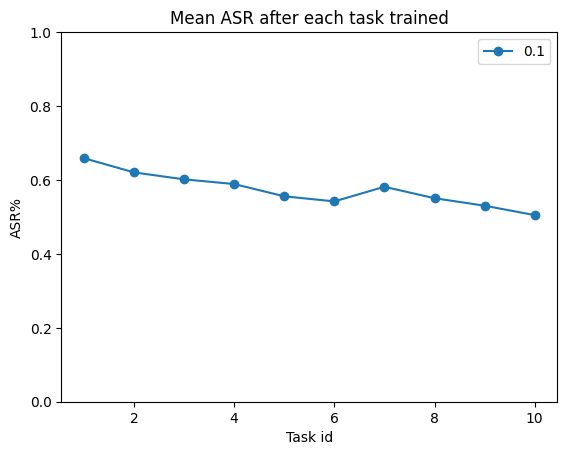

In [26]:
for d in data:
    
    ACC,ASR,poison_rate = d

    title = f"Mean ASR after each task trained"

    plt.plot(np.arange(1,len(ASR)+1),ASR,label=f'{poison_rate}',marker='o')
    plt.title(title)
    plt.ylabel('ASR%')
    plt.legend()
    plt.xlabel('Task id')
    plt.ylim(0,1)